In [1]:
import os
os.environ["THEANO_FLAGS"] = "device=gpu1"
from lasagne.generative.autoencoder import Autoencoder, greedy_learn_with_validation
from lasagne.easy import BatchOptimizer, LightweightModel
from lasagne.datasets.mnist import MNIST

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from lasagne import layers, updates, init, nonlinearities
import theano.tensor as T
from theano.sandbox import rng_mrg
import theano
import matplotlib.pyplot as plt
import numpy as np
from lasagne.layers import get_all_layers

from skimage.io import imread
from skimage.filter import threshold_otsu
from skimage.transform import resize

import matplotlib.pyplot as plt

from lasagne import easy

from lasagne.generative.capsule import Capsule
from lasagne.easy import BatchIterator
import glob
import os

from lasagne.easy import BatchOptimizer, LightweightModel
from lasagne import init
from collections import OrderedDict
from lasagne import init, layers, updates, nonlinearities
from lasagne.layers.helper import get_all_layers
from lasagne.layers import helper
import theano.tensor as T
from theano.sandbox import rng_mrg
from sklearn.cross_validation import train_test_split
from lasagne.datasets.fonts import Fonts
import theano
from collections import OrderedDict
import theano.tensor as T

from lasagne.generative.capsule import Capsule
from lasagne.layers import Layer
%matplotlib inline

def binarize(X):
    X_b = np.empty(X.shape, dtype=X.dtype)
    for i in range(X.shape[0]):
        X_b[i] = 1. * (X[i] <= threshold_otsu(X[i]))
    return X_b

def resize_all(X, w, h):
    if X.shape[1] == w and X.shape[2] == h:
        return X
    X_b = np.empty((X.shape[0], w, h), dtype=X.dtype)
    for i in range(X.shape[0]):
        X_b[i] = resize(X[i], (w, h))
    return X_b  

class SumLayer(Layer):
    def __init__(self, 
                 incoming,
                 axis=1,
                 **kwargs):
        super(SumLayer, self).__init__(incoming, **kwargs)
        self.axis = axis

    def get_output_for(self, input, **kwargs):
        return input.sum(axis=self.axis)
    
    def get_output_shape_for(self, input):
        shape = list(self.input_shape)
        del shape[self.axis]
        return tuple(shape)


%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 1: Tesla K20m


# Load & pre-process data

In [2]:
data = MNIST()
data.load()
X = data.X
X = X.astype(np.float32)
y = data.y.astype(np.int32)

In [3]:
w, h = 28, 28

In [4]:
from skimage.filter import threshold_otsu
from skimage.transform import resize
X_b = np.zeros((X.shape[0], w, h))
for i in range(X_b.shape[0]):
    X_b[i] = resize(X[i].reshape((28, 28)), (w, h))
X = X_b
X = X <= threshold_otsu(X)
X = X.astype(np.float32)
X = 1 - X
X = X.reshape((X.shape[0], w*h))

In [4]:
from sklearn.preprocessing import label_binarize
y = label_binarize(y, np.arange(10))
y = y.astype(np.float32)

In [5]:
output_dim = y.shape[1]

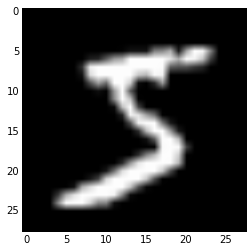

In [6]:
plt.imshow(X[0].reshape((28, 28)), cmap="gray")

In [7]:
X, y = shuffle(X, y)
X, y = X[0:60000], y[0:60000]
train, test = train_test_split(range(X.shape[0]), test_size=0.25)

In [8]:
class MyBatchOptimizer(BatchOptimizer):
    
    def iter_update(self, epoch, nb_batches, iter_update_batch):
        status = super(MyBatchOptimizer, self).iter_update(epoch, nb_batches, iter_update_batch)
        
        s = np.arange(len(train))
        np.random.shuffle(s)
        s_train = s[0:1000]

        
        s = np.arange(len(test))
        np.random.shuffle(s)
        s_test = s[0:1000]

        
        status["acc_train"] = (self.model.predict(X[train][s_train])==y[train][s_train].argmax(axis=1)).mean()
        status["acc_valid"] = (self.model.predict(X[test][s_test])==y[test][s_test].argmax(axis=1)).mean()
        
        status["rec_train"] = self.model.get_reconstruction_error(X[train][s_train])
        status["rec_valid"] = self.model.get_reconstruction_error(X[test][s_test])
        
        status["crosscor_train"] = self.model.get_cross_correlation(X[train][s_train])
        status["crosscor_valid"] = self.model.get_cross_correlation(X[test][s_test])
        return status

## Model definition

In [9]:
from lasagne.layers import cuda_convnet, Conv2DLayer

def cross_entropy(truth, pred):
    return -(truth * T.log(pred) + (1 - truth) * T.log(1 - pred)).sum(axis=1).mean()

def mse(truth, pred):
    return (((truth - pred) ** 2).sum(axis=1)).mean()

def loss_function_y(y_true, y_pred):
    return (T.nnet.categorical_crossentropy(y_pred, y_true)).mean()
        
def build_batch_optimizer():
    #learning_rate = theano.shared(np.array(0.01, dtype="float32"))
    learning_rate = 0.01
    batch_optimizer = MyBatchOptimizer(
        verbose=1,
        max_nb_epochs=100,
        batch_size=100,
        optimization_procedure=(updates.rmsprop, 
                                {"learning_rate": 0.001})
        
    )
    
    batch_optimizer.learning_rate = learning_rate
    return batch_optimizer


def corrupted_masking_noise(rng, x, corruption_level):
    return rng.binomial(size=x.shape, n=1, p=1 - corruption_level) * x

def corrupted_salt_and_pepper(rng, x, corruption_level):
    selected = rng.binomial(size=x.shape, n=1, p=corruption_level, dtype=theano.config.floatX)
    return x * (1 - selected) + selected * rng.binomial(size=x.shape, n=1, p=0.5, dtype=theano.config.floatX)

rng = rng_mrg.MRG_RandomStreams()
 
def corruption_function(X):
    return corrupted_salt_and_pepper(rng, X, 0.5)
    

class Model:
    def get_all_params(self, **t):
        return list(set(self.x_to_z.get_all_params(**t) + 
                        self.x_to_y.get_all_params(**t) + 
                        self.z_to_x.get_all_params(**t)))


In [53]:
## fully connected
latent_size = 2
num_hidden_units = 1000

l_in = layers.InputLayer((None, w*h))
input_dim = w*h
output_dim = y.shape[1]
    
# encoder
l_encoder1 = layers.DenseLayer(l_in, num_units=num_hidden_units)
l_encoder2 = layers.DenseLayer(l_encoder1, num_units=num_hidden_units)
l_encoder3 = layers.DenseLayer(l_encoder2, num_units=num_hidden_units)
l_encoder4 = layers.DenseLayer(l_encoder3, num_units=num_hidden_units)

# learned representation
l_observed = layers.DenseLayer(l_encoder4, num_units=output_dim,
                                  nonlinearity=T.nnet.softmax)

l_latent = layers.DenseLayer(l_encoder4, 
                             num_units=latent_size,
                             nonlinearity=None) # linear

l_representation = layers.concat([l_observed, l_latent])

# decoder
l_decoder1 = layers.DenseLayer(l_representation, num_units=num_hidden_units)
l_decoder2 = layers.DenseLayer(l_decoder1, num_units=num_hidden_units)
l_decoder3 = layers.DenseLayer(l_decoder2, num_units=num_hidden_units)
l_decoder4 = layers.DenseLayer(l_decoder3, num_units=num_hidden_units)
l_decoder_out = layers.DenseLayer(l_decoder4, num_units=input_dim,
                                   nonlinearity=nonlinearities.sigmoid)

x_to_z = LightweightModel([l_in], [l_latent])
x_to_y = LightweightModel([l_in], [l_observed])
z_to_x = LightweightModel([l_observed, l_latent], [l_decoder_out])
model = Model()
model.x_to_z = x_to_z
model.x_to_y = x_to_y
model.z_to_x = z_to_x

In [30]:
## CNN

nb_filters=32
size_filters=5
nb_hidden=500
nb_intermediate=2000
nb_outputs=10
corruption=False

nb_filters_encoder = nb_filters
nb_filters_decoder = nb_filters
size_filters_encoder = size_filters
size_filters_decoder = size_filters

l_in = layers.InputLayer((None, w*h))


x_in_reshaped = layers.ReshapeLayer(l_in, ([0], 1, w, h))

# conv1
l_conv = cuda_convnet.Conv2DCCLayer(
    x_in_reshaped,
    num_filters=nb_filters_encoder,
    filter_size=(size_filters, size_filters_encoder),
    nonlinearity=nonlinearities.rectify,
    dimshuffle=True,
)
l_intermediate = layers.DenseLayer(
    l_conv,
    num_units=nb_intermediate,
    nonlinearity=nonlinearities.rectify,
)
#code layer

l_x_code = layers.DenseLayer(
    l_intermediate,
    num_units=nb_hidden,
    nonlinearity=nonlinearities.linear,
)

l_observed = layers.DenseLayer(l_intermediate, 
                               num_units=output_dim,
                                nonlinearity=T.nnet.softmax)

l_latent = layers.DenseLayer(l_intermediate, 
                             num_units=10,
                             nonlinearity=None) # linear

hid = layers.ConcatLayer([l_latent, l_observed], axis=1)


# unflatten layer
hid = layers.DenseLayer(hid,
                        num_units=nb_filters_decoder * (w - size_filters_decoder + 1) * (h - size_filters_decoder + 1))
hid = layers.ReshapeLayer(hid,
                          ([0], nb_filters_decoder, (w - size_filters_decoder + 1), (h - size_filters_decoder + 1)))

l_unconv = Conv2DLayer(
    hid,
    num_filters=32,
    filter_size=(size_filters_decoder, size_filters_decoder),
    nonlinearity=nonlinearities.rectify,
    border_mode="full"
)
l_unconv_sum = SumLayer(l_unconv, axis=1)
l_decoder_out = layers.ReshapeLayer(l_unconv_sum, ([0], w*h))
l_decoder_out = layers.NonLinearityLayer(l_decoder_out, nonlinearities.sigmoid)

x_to_z = LightweightModel([l_in], [l_latent])
x_to_y = LightweightModel([l_in], [l_observed])
z_to_x = LightweightModel([l_observed, l_latent], [l_decoder_out])
model = Model()
model.x_to_z = x_to_z
model.x_to_y = x_to_y
model.z_to_x = z_to_x

In [54]:
def cross_correlation(a, b):
    a = a - a.mean(axis=0)
    b = b - b.mean(axis=0)
    return 0.5 * ((((a.dimshuffle(0, 'x', 1) * b.dimshuffle(0, 1, 'x'))).mean(axis=0))**2).sum()

input_variables = OrderedDict()
input_variables["X"] = dict(tensor_type=T.matrix)
input_variables["y"] = dict(tensor_type=T.matrix)
    

functions = dict(
    encode=dict(
        get_output=lambda model, X:model.x_to_z.get_output(X)[0],
        params=["X"]
    ),
    predict=dict(
        get_output=lambda model, X:(model.x_to_y.get_output(X)[0]).argmax(axis=1),
        params=["X"]
    ),
    reconstruct=dict(
        get_output=lambda model, X: l_decoder_out.get_output(X),
        params=["X"]
    ),
    get_reconstruction_error=dict(
        get_output=lambda model, X: ((X-l_decoder_out.get_output(X))**2).sum(axis=1).mean(),
        params=["X"]
    ),
    get_cross_correlation=dict(
        get_output=lambda model, X: cross_correlation(model.x_to_z.get_output(X)[0],
                                                      model.x_to_y.get_output(X)[0]),
        params=["X"]
    ),
    predict_proba=dict(
        get_output=lambda model, X: model.x_to_y.get_output(X)[0],
        params=["X"]
    )

)

batch_optimizer = MyBatchOptimizer(
    verbose=1,
    max_nb_epochs=100,
    batch_size=100,
    optimization_procedure=(updates.rmsprop, 
                            {"learning_rate": 0.0001})
)



def loss_function(model, tensors):
    x_to_z, x_to_y, z_to_x = model.x_to_z, model.x_to_y, model.z_to_x
    X_batch, y_batch = tensors["X"], tensors["y"]
    
    z, = x_to_z.get_output(X_batch)

    
    y_hat, = x_to_y.get_output(X_batch)
    X_hat, = z_to_x.get_output(y_hat, z)
    
    loss_rec = ((X_hat - X_batch) ** 2).sum(axis=1).mean()
    loss_supervised = ((y_hat - y_batch)**2).sum(axis=1).mean()
    
    return  loss_rec + 10* loss_supervised + 10 * cross_correlation(z, y_hat)
    
capsule = Capsule(
    input_variables, 
    model,
    loss_function,
    functions=functions,
    batch_optimizer=batch_optimizer,
)
Z_batch = T.matrix("z_batch")
capsule.decode = theano.function([Z_batch, capsule.v_tensors["y"]], 
                                  l_decoder_out.get_output({l_latent: Z_batch, 
                                                            l_observed: capsule.v_tensors["y"]}))


/grid_mnt/vol__vol_U__u/gridcl/mehdicherti/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:75: UserWarning: layer.get_output(...) is deprecated and will be removed for the first release of Lasagne. Please use lasagne.layers.get_output(layer, ...) instead.


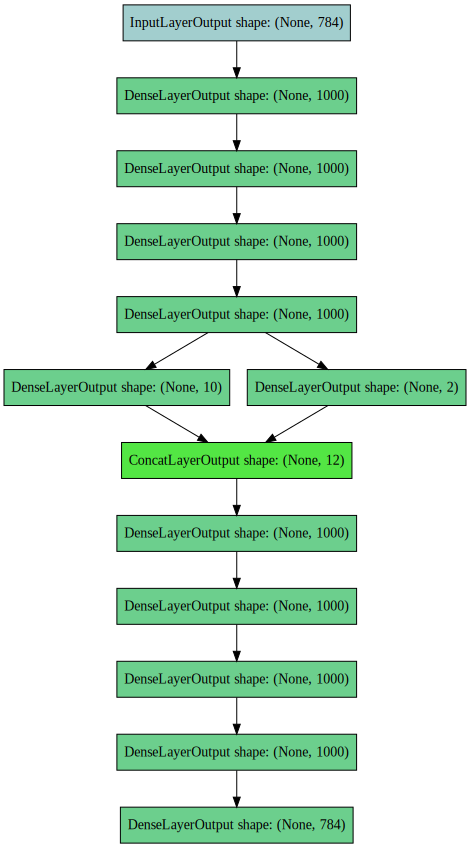

In [143]:
from lasagne.misc.draw_net import draw_to_file
draw_to_file(get_all_layers(l_decoder_out), "model.svg")

from IPython.display import SVG
SVG("model.svg")

## Training 

In [55]:
capsule.fit(X=X[train], y=y[train])

/grid_mnt/vol__vol_U__u/gridcl/mehdicherti/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: UserWarning: layer.get_output(...) is deprecated and will be removed for the first release of Lasagne. Please use lasagne.layers.get_output(layer, ...) instead.
/grid_mnt/vol__vol_U__u/gridcl/mehdicherti/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:25: UserWarning: layer.get_output(...) is deprecated and will be removed for the first release of Lasagne. Please use lasagne.layers.get_output(layer, ...) instead.


  epoch    loss_std    loss_train    acc_train    acc_valid    rec_train    rec_valid    crosscor_train    crosscor_valid
-------  ----------  ------------  -----------  -----------  -----------  -----------  ----------------  ----------------
      0     17.8197       53.7228        0.933        0.927      40.0787      39.9736         0.0298151         0.0326621
  epoch    loss_std    loss_train    acc_train    acc_valid    rec_train    rec_valid    crosscor_train    crosscor_valid
-------  ----------  ------------  -----------  -----------  -----------  -----------  ----------------  ----------------
      1     2.62993       38.1136        0.938        0.932      33.5323      33.4396        0.00901238        0.00746985
  epoch    loss_std    loss_train    acc_train    acc_valid    rec_train    rec_valid    crosscor_train    crosscor_valid
-------  ----------  ------------  -----------  -----------  -----------  -----------  ----------------  ----------------
      2     1.66749     

In [56]:
!nvidia-smi

Sat Jul 25 01:44:56 2015       
+------------------------------------------------------+                       
| NVIDIA-SMI 5.319.37   Driver Version: 319.37         |                       
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K20m          Off  | 0000:05:00.0     Off |                    0 |
| N/A   26C    P8    15W / 225W |       13MB /  4799MB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K20m          Off  | 0000:42:00.0     Off |                    0 |
| N/A   53C    P0    50W / 225W |      873MB /  4799MB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

(1000,)


TypeError: Invalid dimensions for image data

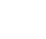

In [46]:
from lasagne.misc.plot_weights import grid_plot
layers_enc = get_all_layers(model.x_to_z.output_layers[0])
layers_dec = get_all_layers(model.z_to_x.output_layers[0])

for l in layers_enc[2], layers_dec[-3]:
    plt.clf()
    W = l.W.get_value()[:, 0]
    print(W.shape)
    grid_plot(W, imshow_options={"cmap": "gray"})
    plt.show()

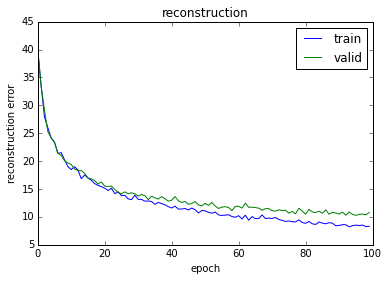

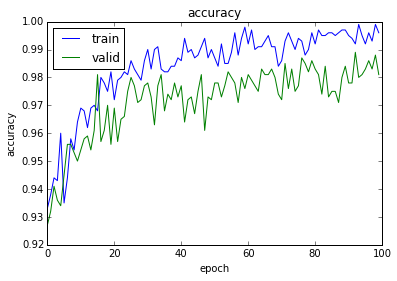

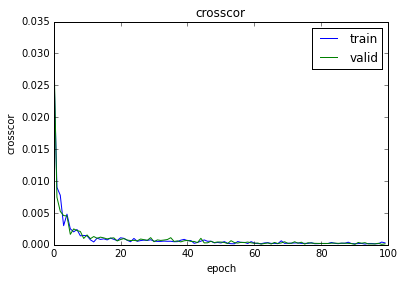

In [57]:
from lasagne.easy import get_stat

layer = 0
train_stat = get_stat("rec_train", capsule.batch_optimizer.stats)
test_stat = get_stat("rec_valid", capsule.batch_optimizer.stats)

plt.plot(train_stat, label="train")
plt.plot(test_stat, label="valid")
plt.xlabel("epoch")
plt.ylabel("reconstruction error")
plt.legend()
plt.title("reconstruction")
plt.show()

epoch = get_stat("epoch", capsule.batch_optimizer.stats)
acc_train = get_stat("acc_train", capsule.batch_optimizer.stats)
acc_valid = get_stat("acc_valid", capsule.batch_optimizer.stats)
plt.title("accuracy")
plt.plot(acc_train, label="train")
plt.plot(acc_valid, label="valid")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc='best')
plt.show()

epoch = get_stat("epoch", capsule.batch_optimizer.stats)
acc_train = get_stat("crosscor_train", capsule.batch_optimizer.stats)
acc_valid = get_stat("crosscor_valid", capsule.batch_optimizer.stats)
plt.title("crosscor")
plt.plot(acc_train, label="train")
plt.plot(acc_valid, label="valid")
plt.xlabel("epoch")
plt.ylabel("crosscor")
plt.legend(loc='best')
plt.show()

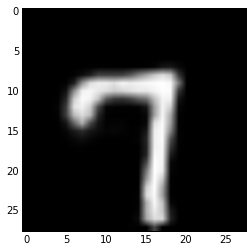

In [58]:
nb = 100
T_ = train
x = X[T_][0:100]
nb_outputs = y.shape[1]

from IPython.html.widgets import (interact, interactive, 
                                  IntSliderWidget, IntSlider, FloatSliderWidget,
                                  ButtonWidget
                                  )
from IPython.display import display # Used to display widgets in the notebook

from IPython.html.widgets import *
from IPython.html import widgets

z = capsule.encode(x)
print(z.shape)
if z.shape[1] > 10:
    params = np.random.choice(z.shape[1],
                              size=10)
else:
    params = np.arange(z.shape[1])

boundaries = OrderedDict()
for p in (params):
    boundaries["{0}".format(p)] = FloatSliderWidget(min=z[:, p].min(),
                                                    max=z[:, p].max(),
                                                    step=0.01,
                                                    value=0.)
 
d = 0
l = y[T_][d].argmax() 



def draw(example, label, true_label, zero_activations, **params):
    z = capsule.encode(x[example:example + 1])
    
    if true_label:
        y_ = capsule.predict_proba(x[example:example + 1])
    else:
        y_ = np.zeros(nb_outputs, dtype='float32')
        y_[label] = 1.
        y_ = y_[np.newaxis, :]
        
    if zero_activations:
        z[0, :] = 0
    for k, v in params.items():
        z[0][int(k)] = v
    plt.imshow(capsule.decode(z, y_)[0].reshape((28, 28)), cmap="gray")
    
example_selector = IntSliderWidget(min=0,max=nb-1,step=1,value=d)
label_selector = IntSliderWidget(min=0,max=9,step=1,value=l)
i = interact(example=example_selector,
          label=label_selector, 
          true_label=True,
          zero_activations=False,
          **boundaries)


def on_button_clicked(b):
    
    example = example_selector.get_state()["value"]
    z = capsule.encode(x[example:example + 1])
    for p in params:
        w = boundaries["{0}".format(p)]
        state = w.get_state()
        state["value"] = z[0, int(p)]
        w.set_state(state)
        w.send_state(state)
        
    state = label_selector.get_state()
    state["value"] = y[example].argmax()
    label_selector.set_state(state)
    label_selector.send_state(state)
    
    
draw_i = i(draw)

button = widgets.ButtonWidget(description="fit!")
display(button)

button.on_click(on_button_clicked)



In [59]:
nb = 10
x_ = X[test][0:nb]
x_hat_ = capsule.reconstruct(x_)

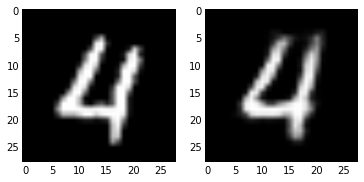

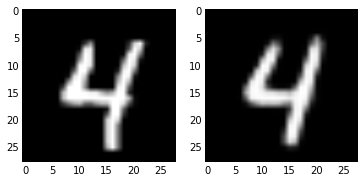

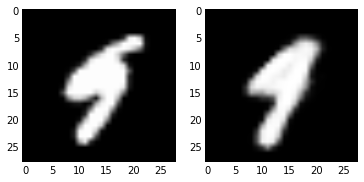

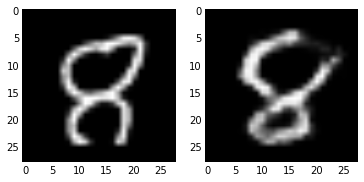

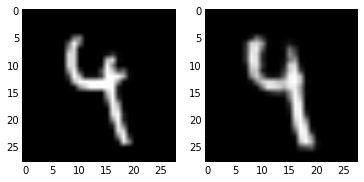

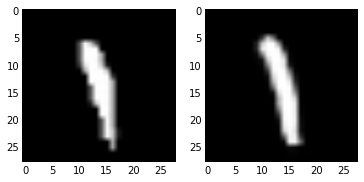

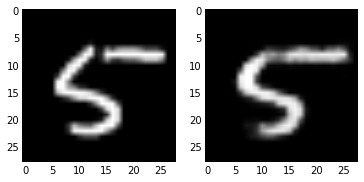

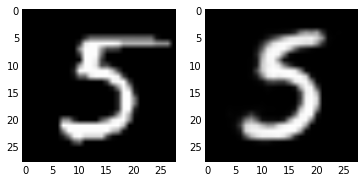

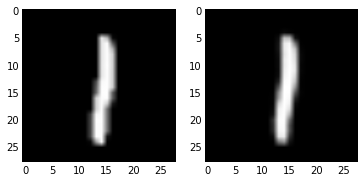

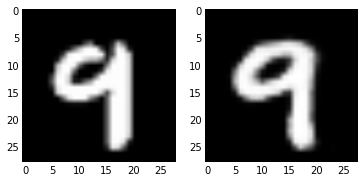

In [50]:
for i in range(nb):
    plt.clf()
    plt.subplot(1, 2, 1)
    plt.imshow(x_[i].reshape((w, h)), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(x_hat_[i].reshape((w, h)), cmap="gray")
    plt.show()

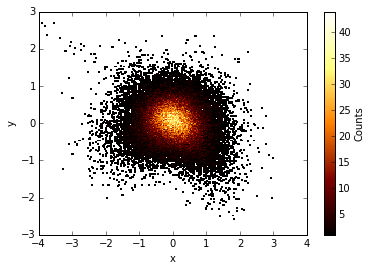

In [157]:
# SOurce :http://oceanpython.org/2013/02/25/2d-histogram/

x_ = X[train]
z = capsule.encode(x_)

# Estimate the 2D histogram
nbins = 200
H, xedges, yedges = np.histogram2d(z[:, 0],z[:, 1],bins=nbins)
 
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
 
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
 
# Plot 2D histogram using pcolor
fig2 = plt.figure()
plt.pcolormesh(xedges,yedges,Hmasked, cmap="afmhot")
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')

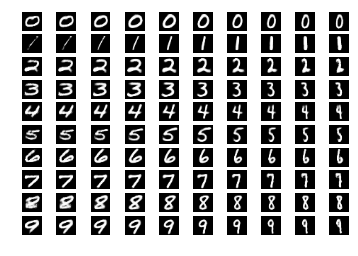

In [142]:
from lasagne.misc.plot_weights import grid_plot
latent_dim = 1
L = latent_size
nb = 10

ys = np.eye(output_dim).repeat(nb, axis=0)
seq = np.linspace(-2, 2, nb)

z = np.zeros((nb, L))
z[:, latent_dim] = seq
z = z.repeat(nb, axis=0).reshape((nb, output_dim, L)).transpose((1, 0, 2)).reshape((nb*output_dim, L))
z = z.astype(np.float32)
ys = ys.astype(np.float32)

c = capsule.decode(z, ys)
c = c.reshape((c.shape[0], w, h))
grid_plot(c, imshow_options=dict(cmap="gray"), nbrows=10, nbcols=10)